Análise do dia 17/03 através do modelo LDA.

In [1]:
# Importar bibliotecas

# gerais
import sys
import os
from pathlib import Path
import re
import numpy as np
import pandas as pd
from pprint import pprint
from tqdm import tqdm
from ast import literal_eval

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.ldamulticore import LdaMulticore

# NLTK Stop words
import nltk
from nltk.corpus import stopwords

#plot
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
%matplotlib inline
from wordcloud import WordCloud, STOPWORDS

In [2]:
# Criando stopwords em português utilizando a biblioteca nltk

nlp = spacy.load("pt_core_news_sm")
pt_stopwords = sorted([token.text for token in nlp.vocab if token.is_stop])
list_exclude = ['obrigado', 'bom', 'mal', 'nenhuma', 'maior', 
             'bem', 'não', 'máximo', 'boa', 'mais',
               'bastante', 'certamente', 'certeza', 'contra',
                'quarentena', 'coronavírus', 'presidente', 'impeachment', 'demitido', 'demitida']
for word in list_exclude:
    nlp.vocab[word].is_stop = False
list_include = set(['o', 'a', 'tá', 'ta', 'ser', 'pro', 'to', 'tô', 'vc', 'você', 'voce', 'pra',
                    'pq', 'é', 'vou', 'que','tão', 'gt', 'de', 'da', 'do', 'em', 'uma', 'lá',
                    'já', 'no', 'para', 'na', 'com', 'um', 'minha', 'se', 'isso', 'por', 'vou',
                    'os', 'isso', 'como', 'mesmo', 'tenho', 'aqui', 'ele', 'ela', 'quem', 'fazer',
                    'eu', 'só', 'ai', 'mais', 'só', 'querer', 'https', 'ter', 'estar', 'ficar',
                    'dos', 'das', 'vcs', 'jairbolsonaro', 'tava', 'nao', 'sao', 'ja', 'so', 'nossa',
                    'nosso', 'estao', 'tco', 'me', 'dia', 'te', 'ver', 'sera', 'porra', 'fez', 'ne',
                    'kkkkkk', 'puta', 'kkkkkkkk', 'hj', 'afff', 'gbr', 'meu', 'cara', 'guri', 'cmg',
                    'ctg', 'agr', 'pqp', 'vdd', 'eh', 'va', 'fudeu', 'fuder', 'fodeu', 'foda', 'obg',
                   'nem', 'numa', 'num', 'nuns', 'ces', 'voces', 'oce', 'oces', 'kkkk', 'vao', 'via',
                    'hj', 'hoje', 'tudo', 'todo', 'toda', 'ir', 'vir', 'bem', 'sair', 'tao']
                  )
for w in list_include:
    nlp.vocab[w].is_stop = True
stop_words = sorted([token.text for token in nlp.vocab if token.is_stop])

# Preparação dos dados

In [3]:
# import dos dados

df = pd.read_csv('0317_preprocessado.csv')

In [4]:
# import dos tokens

df_tokens = pd.read_csv('tokens_unicos_10k.csv')

In [5]:
# criação de lista de tokens

lista_token = []

for row in range(0, len(df_tokens)):
    lista_token.append(df_tokens.iloc[row,1])
    
lista_token = set(lista_token)

In [6]:
# filtranso os tokens para aparecer apenas os 10 mil mais frequentes

df['token2'] = df.token.apply(lambda x: str(list(set(literal_eval(x)).intersection(lista_token))))

In [7]:
# função para reverter os tokens processados em lista de tuples

def strip_characters(text):
    t = re.sub(r'\(|\)|:|,|;|\.|’|”|“|\?|%|>|<|\[|\]', '', text)
    t = re.sub(r'/', ' ', t)
    t = t.replace("'",'')
    return t

In [8]:
# aplica função em todos os tokens

df['token2'] = df['token2'].apply(lambda x: strip_characters(x))
df['token2'] = df['token2'].apply(lambda x: str(x).split(' '))

In [9]:
# transforma os tokens em lista

lista = list(df['token2'])

In [10]:
# Build the bigram and trigram models

bigram = gensim.models.Phrases(lista, min_count=5, threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)

trigram = gensim.models.Phrases(bigram[lista], threshold=100)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [11]:
# função para preprocessar palavras

def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts1 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts2 = [bigram_mod[doc] for doc in texts1]
    texts3 = [trigram_mod[bigram_mod[doc]] for doc in texts2]
    texts4 = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts3]    
    return texts4

In [12]:
# Processing the abstract

texto = process_words(lista)

# Modelagem

In [13]:
# Criar dicionário

id2word = corpora.Dictionary(texto)

In [14]:
# Criar o Corpus: A Frequência das palavras nos documentos

corpus = [id2word.doc2bow(text) for text in texto]

In [15]:
# Função para determinar a melhor quantidade de tópicos para a modelagem

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=5):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaMulticore(corpus, id2word=id2word, num_topics=10)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [16]:
# Colocando parametros na função

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=texto, start=2, limit=30, step=2)

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [09:54<00:00, 42.50s/it]


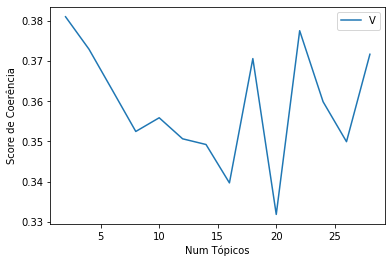

In [17]:
# Mostrando visualmente a quantidade de tópicos

limit=30; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Tópicos")
plt.ylabel("Score de Coerência")
plt.legend(("Valores de Coerência"), loc='best')
plt.show()

In [18]:
# Lista dos valores de coerência, para melhor identificar o ponto de inflexão do gráfico

for m, cv in zip(x, coherence_values):
    print("A quantidade de tópicos =", m, " tem um valor de coerência de ", round(cv, 4))

A quantidade de tópicos = 2  tem um valor de coerência de  0.381
A quantidade de tópicos = 4  tem um valor de coerência de  0.373
A quantidade de tópicos = 6  tem um valor de coerência de  0.3627
A quantidade de tópicos = 8  tem um valor de coerência de  0.3525
A quantidade de tópicos = 10  tem um valor de coerência de  0.3559
A quantidade de tópicos = 12  tem um valor de coerência de  0.3506
A quantidade de tópicos = 14  tem um valor de coerência de  0.3492
A quantidade de tópicos = 16  tem um valor de coerência de  0.3397
A quantidade de tópicos = 18  tem um valor de coerência de  0.3706
A quantidade de tópicos = 20  tem um valor de coerência de  0.3318
A quantidade de tópicos = 22  tem um valor de coerência de  0.3775
A quantidade de tópicos = 24  tem um valor de coerência de  0.3599
A quantidade de tópicos = 26  tem um valor de coerência de  0.3499
A quantidade de tópicos = 28  tem um valor de coerência de  0.3717


Aqui conseguimos determinar a melhor quantidade de tópicos a serem analisados, que é 8 tópicos

In [19]:
# Vamos agora construir de fato o modelo LDA

lda_model = LdaMulticore(corpus=corpus,
                        id2word=id2word,
                        num_topics=4, 
                        random_state=42,
                        chunksize=100,
                        passes=10,
                        per_word_topics=True)

In [20]:
# Computar a perplexidade do modelo (quanto menor, melhor)

print('\nPerplexidade: ', lda_model.log_perplexity(corpus))


Perplexidade:  -6.398423192166341


In [21]:
# Computar o Score de Coerência

coherence_model_lda = CoherenceModel(model=lda_model, texts=lista, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nScore de Coerência: ', coherence_lda)


Score de Coerência:  0.36053598343460747


In [22]:
# Visualização dos tópicos em clusters

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.215676 -0.226866       1        1  34.801205
1      0.216193 -0.133652       2        1  28.062328
0      0.267079  0.142962       3        1  19.990108
2     -0.267595  0.217557       4        1  17.146355, topic_info=           Term          Freq         Total Category  logprob  loglift
0        corona  65381.000000  65381.000000  Default  30.0000  30.0000
5         virus  27134.000000  27134.000000  Default  29.0000  29.0000
14   presidente  24537.000000  24537.000000  Default  28.0000  28.0000
42    bolsonaro  20761.000000  20761.000000  Default  27.0000  27.0000
51       brasil   4459.000000   4459.000000  Default  26.0000  26.0000
..          ...           ...           ...      ...      ...      ...
49        falar   1077.057129   2362.751953   Topic4  -4.5218   0.9778
2         gente   1028.605835   4596.208984   Topic4  -4.5678   0.2664
36        muito    733.800476   3370.652588   Topic4  -4.9055   0.2388
25         casa    747.405518   4925.532227   Topic4  -4.8871  -0.1222
287       coisa    594.104492   2118.419922   Topic4  -5.1167   0.4920

[209 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
152       3  0.999567  acabar
17        1  0.572040   agora
17        2  0.243952   agora
17        3  0.183944   agora
124       1  0.563848   ainda
...     ...       ...     ...
357       4  0.998545   video
5         1  0.999971   virus
465       4  0.998251   volta
198       1  0.998647  voltar
471       3  0.998550    voto

[211 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 1, 3])

In [23]:
# Escolhe o modelo

optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.116*"bolsonaro" + 0.030*"contra" + 0.026*"presidente" + 0.015*"corona" + '
  '0.011*"governo" + 0.009*"saude" + 0.009*"sempre" + 0.008*"preso" + '
  '0.008*"janaina" + 0.008*"quando"'),
 (1,
  '0.064*"corona" + 0.045*"presidente" + 0.028*"risco" + 0.026*"virus" + '
  '0.022*"grupo" + 0.020*"povo" + 0.018*"bolsonaro" + 0.014*"cada" + '
  '0.012*"congresso" + 0.009*"fechar"'),
 (2,
  '0.207*"presidente" + 0.027*"povo" + 0.027*"brasil" + 0.023*"bolsonaro" + '
  '0.010*"parabens" + 0.010*"muito" + 0.010*"eleito" + 0.010*"senhor" + '
  '0.009*"brasileiro" + 0.009*"contra"'),
 (3,
  '0.092*"corona" + 0.049*"gente" + 0.041*"presidente" + 0.036*"virus" + '
  '0.014*"nunca" + 0.012*"agora" + 0.010*"morrer" + 0.010*"ainda" + '
  '0.008*"teste" + 0.008*"globo"'),
 (4,
  '0.120*"corona" + 0.034*"ainda" + 0.024*"bolsonaro" + 0.022*"casa" + '
  '0.018*"virus" + 0.014*"gente" + 0.014*"assim" + 0.011*"mal" + 0.011*"mundo" '
  '+ 0.008*"evitar"'),
 (5,
  '0.084*"bolsonaro" + 0.031*"presidente

In [24]:
# Encontrar qual o principal tópico em cada tweet

def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=lista):
    # Output
    sent_topics_df = pd.DataFrame()

    # Seleciona o principal tópico de cada tweet
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Calcula o principal tópico, o percentual de contribuição e as palavras chaves de cada tweet
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => mostra o principal tópico
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Principal_Topico', 'Perc_Contributicao', 'Palavras_Chave']

    # Inclui o texto original no final do DataFrame
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [25]:
# roda a função de calcular os principais tópicos de cada tweet

df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=lista)

In [26]:
# Formata o DataFrame

df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Index_DF_Original', 'Principal_Topico', 'Perc_Contrib_Topico', 'Palavras_Chave', 'Tweets']

In [27]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Principal_Topico')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contributicao'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topico', "Topico_Perc_Contrib", "Palavras_Chave", "Tweet"]

# Show
sent_topics_sorteddf_mallet

,Topico,Topico_Perc_Contrib,Palavras_Chave,Tweet
0,0.0,0.9400,"bolsonaro, contra, presidente, corona, governo...","[tco, lixo, bolsonaro, barco, bolsonaroacabou,..."
1,1.0,0.9308,"corona, presidente, risco, virus, grupo, povo,...","[presidente, hipocrisia, dos, senado, morte, m..."
2,2.0,0.9437,"presidente, povo, brasil, bolsonaro, parabens,...","[presidente, torcer, picuinha, contra, duro, n..."
3,3.0,0.9470,"corona, gente, presidente, virus, nunca, agora...","[sp, corona, globo, falar, jovem, estadao, gra..."
4,4.0,0.9437,"corona, ainda, bolsonaro, casa, virus, gente, ...","[cm, fisico, gente, inclusive, sao, vcs, senti..."
5,5.0,0.9400,"bolsonaro, presidente, corona, irresponsavel, ...","[tco, fogo, desde, bolsonaro, dia, incrivel, e..."
6,6.0,0.9400,"corona, presidente, nada, cu, virus, mao, casa...","[corona, estudante, maos, nivel, muito, ne, ba..."
7,7.0,0.9500,"corona, virus, pegar, casa, medo, mundo, agora...","[praia, pobre, muito, pegar, dinheiro, fudido,..."
8,8.0,0.9500,"bolsonaro, presidente, coronavirus, brasil, go...","[saude, situacao, bolsonaro, contra, coronavir..."
9,9.0,0.9500,"corona, virus, vairus, mae, casa, passar, agor...","[vez, ganhar, olhar, casa, dar, dia, agora, tu..."


In [28]:
# Numero de tweets por topico

topic_counts = df_topic_sents_keywords['Principal_Topico'].value_counts()

# Porcentagem de tweets por tópico
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Número do tópico e suas palavras chave
topic_num_keywords = df_topic_sents_keywords[['Principal_Topico', 'Palavras_Chave']]

# Concatena as colunas
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Renomeia as colunas
df_dominant_topics.columns = ['Principal_Topico', 'Palavras_Chave', 'Qtd_Tweets', 'Perc_Tweets']

# Mostra o DataFrame
df_dominant_topics

,Principal_Topico,Palavras_Chave,Qtd_Tweets,Perc_Tweets
0.0,4.0,"corona, ainda, bolsonaro, casa, virus, gente, ...",5680.0,0.0501
1.0,7.0,"corona, virus, pegar, casa, medo, mundo, agora...",3702.0,0.0326
2.0,1.0,"corona, presidente, risco, virus, grupo, povo,...",13782.0,0.1215
3.0,7.0,"corona, virus, pegar, casa, medo, mundo, agora...",6399.0,0.0564
4.0,7.0,"corona, virus, pegar, casa, medo, mundo, agora...",6544.0,0.0577
...,...,...,...,...
113432.0,9.0,"corona, virus, vairus, mae, casa, passar, agor...",NaN,NaN
113433.0,6.0,"corona, presidente, nada, cu, virus, mao, casa...",NaN,NaN
113434.0,3.0,"corona, gente, presidente, virus, nunca, agora...",NaN,NaN
113435.0,5.0,"bolsonaro, presidente, corona, irresponsavel, ...",NaN,NaN


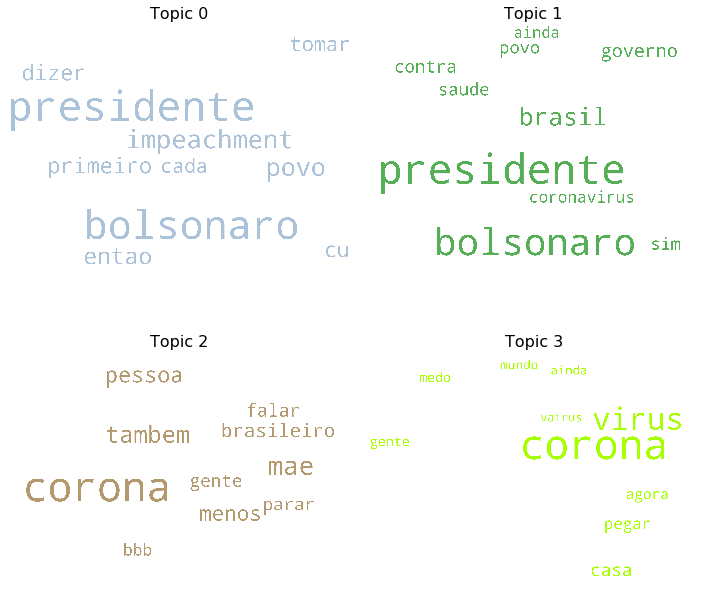

In [29]:
# Cria wordclouds

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()